In [1]:
# Con este Notebook se realizará la carga y procesado de registros logs de la arquitectura
#   de microservicios desarrollada en docker para el sistema de información ADSB
#   Se extrae la información de latencia de los consumidores Redis en cada test, tantos como indicara la configuración del test

In [2]:
# Importación de librerías necesarias
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta

In [3]:
# Configuración previa para tratar los archivos
carpeta_raiz = "./"  # Carpeta con test1, test2, ...
ventana_segundos = 10  # Tamaño de agregación temporal

In [4]:
# Función auxiliar para procesar las latencias
def extraer_latencias_con_tiempo(ruta):
    mensajeria = []
    almacenamiento = []
    with open(ruta, 'r') as f:
        for linea in f:
            if 'Latencia_mensajeria' in linea:
                m = re.search(r'^(.+?) - INFO - .*?\*\*\*Latencia_mensajeria\*\*\*(\d+\.?\d*)\*\*\*ms', linea)
                if m:
                    ts = datetime.strptime(m.group(1).strip(), "%Y-%m-%d %H:%M:%S,%f")
                    mensajeria.append((ts, float(m.group(2))))
            elif 'Latencia_ConsumidorRedis' in linea:
                m = re.search(r'^(.+?) - INFO - .*?\*\*\*Latencia_ConsumidorRedis\*\*\*(\d+\.?\d*)\*\*\*ms', linea)
                if m:
                    ts = datetime.strptime(m.group(1).strip(), "%Y-%m-%d %H:%M:%S,%f")
                    almacenamiento.append((ts, float(m.group(2))))
    return mensajeria, almacenamiento


# Función auxiliar para agrupar en periodos temporales
def agregar_por_ventanas(lista_ts_valores, ventana_s):
    if not lista_ts_valores:
        return []

    lista_ts_valores.sort(key=lambda x: x[0])
    inicio = lista_ts_valores[0][0]
    fin = lista_ts_valores[-1][0]

    ventana = timedelta(seconds=ventana_s)
    actual = inicio
    agregados = []

    while actual <= fin:
        siguiente = actual + ventana
        valores = [v for t, v in lista_ts_valores if actual <= t < siguiente]
        if valores:
            promedio = sum(valores) / len(valores)
            agregados.append((actual, promedio))
        actual = siguiente

    return agregados

# Función auxiliar realizar los gráficos truncando el eje al inicio de operaciones por los consumidores en cada caso
def graficar_latencias_normalizadas(diccionario_ts, titulo, ylabel):
    plt.figure(figsize=(10, 5))
    for test_num in sorted(diccionario_ts.keys()):
        datos_agregados = agregar_por_ventanas(diccionario_ts[test_num], ventana_segundos)
        if not datos_agregados:
            continue
        inicio_test = datos_agregados[0][0]
        tiempos_relativos = [(t - inicio_test).total_seconds() for t, _ in datos_agregados]
        valores = [v for _, v in datos_agregados]
        plt.plot(tiempos_relativos, valores, label=f"Test {test_num}")
    plt.title(titulo)
    plt.xlabel(f"Tiempo de test (s)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
# Carga de archivos, proceso para separar las líneas de interés y almacenarlas 

resultados_mensajeria_ts = defaultdict(list)
resultados_almacenamiento_ts = defaultdict(list)

for carpeta_test in sorted(os.listdir(carpeta_raiz)):
    if not carpeta_test.startswith("test"):
        continue
    test_num = int(re.search(r'test(\d+)', carpeta_test).group(1))
    ruta_test = os.path.join(carpeta_raiz, carpeta_test)
    if not os.path.isdir(ruta_test):
        continue

    for archivo in os.listdir(ruta_test):
        if not archivo.startswith("consumidor_redis"):
            continue
        ruta_archivo = os.path.join(ruta_test, archivo)
        mensajeria, almacenamiento = extraer_latencias_con_tiempo(ruta_archivo)
        resultados_mensajeria_ts[test_num].extend(mensajeria)
        resultados_almacenamiento_ts[test_num].extend(almacenamiento)


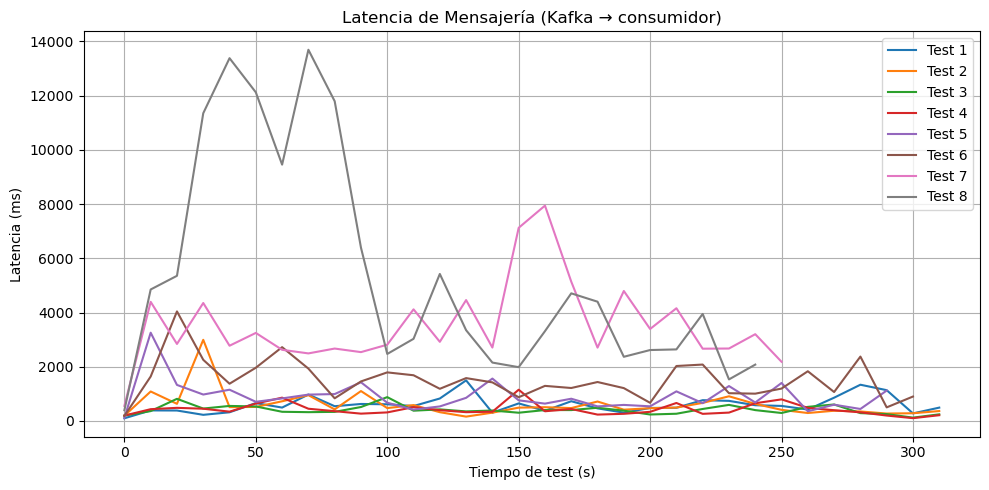

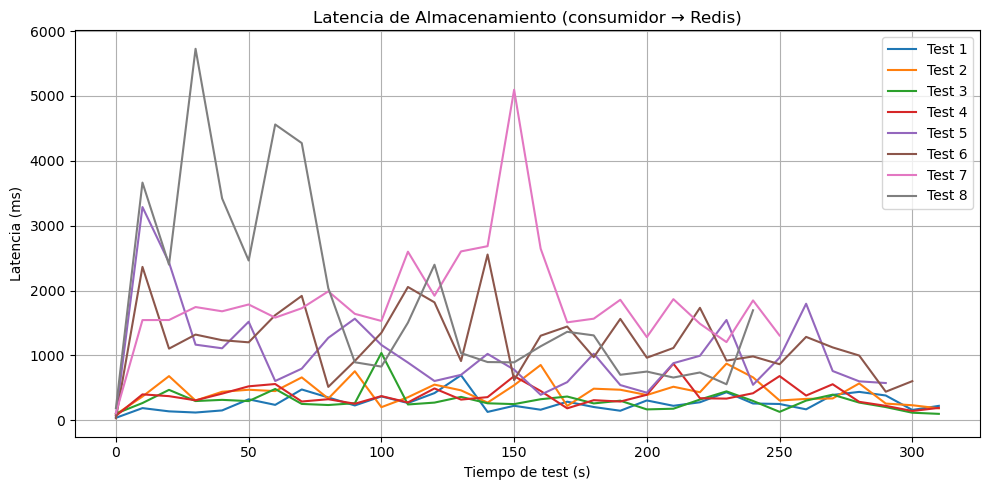

In [6]:
# Agrupar la información y presentarla gráficamente
# Se realiza un escalado de las muestras adapatada al tiempo de test, según TEST.sh es de 300 segundos

graficar_latencias_normalizadas(resultados_mensajeria_ts, "Latencia de Mensajería (Kafka → consumidor)", "Latencia (ms)")
graficar_latencias_normalizadas(resultados_almacenamiento_ts, "Latencia de Almacenamiento (consumidor → Redis)", "Latencia (ms)")
